In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import math
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(1122)

Using cuda device


In [34]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])


In [35]:
class SmallNN(nn.Module):
    def __init__(self):
        super(SmallNN, self).__init__()
        self.lin1 = nn.Linear(1, 4)
        self.lin2 = nn.Linear(4, 8)
        self.lin3 = nn.Linear(8, 4)
        self.lin4 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        return self.lin4(x)

model = SmallNN().to(device)
L = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
model, device

(SmallNN(
   (lin1): Linear(in_features=1, out_features=4, bias=True)
   (lin2): Linear(in_features=4, out_features=8, bias=True)
   (lin3): Linear(in_features=8, out_features=4, bias=True)
   (lin4): Linear(in_features=4, out_features=1, bias=True)
 ),
 'cuda')

In [36]:
import torch.profiler

epochs = 2000

X = torch.randn(1000, 1).to(device)
Y = gaussian_mixture(X).to(device)

def training_step():
    y_pred = model(X)
    loss = L(y_pred, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (e + 1) % 100 == 0:
        print(f"Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}")
        print(torch.cuda.utilization())

def time_pytorch_function(func):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func()

    start.record()
    func()
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)

time_pytorch_function(training_step)

with torch.autograd.profiler.profile(use_device='cuda') as prof:
    for e in range(epochs):
        y_pred = model(X)
        loss = L(y_pred, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (e + 1) % 100 == 0:
            print(f"Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}")
            print(torch.cuda.utilization())
            #free, total = torch.cuda.mem_get_info(device)
            #mem_used_MB = (total - free) / 1024 ** 2
            #print(mem_used_MB)
            #print(torch.cuda.memory_summary())
    # nvidia-smi -lms 100 --query-gpu=index,gpu_name,memory.total,memory.used,memory.free,temperature.gpu,pstate,utilization.gpu,utilization.memory --format=csv

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
prof.export_chrome_trace("trace_with_grad_GPU.json")

Epoch [2000/2000], Loss: 1.7826
4
Epoch [2000/2000], Loss: 0.4546
4
Epoch [2000/2000], Loss: 0.4103
4
Epoch [2000/2000], Loss: 0.3771
4
Epoch [2000/2000], Loss: 0.3520
4
Epoch [2000/2000], Loss: 0.3281
4
Epoch [100/2000], Loss: 0.0765
59
Epoch [200/2000], Loss: 0.0742
40
Epoch [300/2000], Loss: 0.0674
40
Epoch [400/2000], Loss: 0.0615
40
Epoch [500/2000], Loss: 0.0601
47
Epoch [600/2000], Loss: 0.0621
40
Epoch [700/2000], Loss: 0.0615
33
Epoch [800/2000], Loss: 0.0624
40
Epoch [900/2000], Loss: 0.0579
46
Epoch [1000/2000], Loss: 0.0583
41
Epoch [1100/2000], Loss: 0.0558
36
Epoch [1200/2000], Loss: 0.0512
37
Epoch [1300/2000], Loss: 0.0465
34
Epoch [1400/2000], Loss: 0.0406
37
Epoch [1500/2000], Loss: 0.0361
36
Epoch [1600/2000], Loss: 0.0323
35
Epoch [1700/2000], Loss: 0.0282
22
Epoch [1800/2000], Loss: 0.0277
16
Epoch [1900/2000], Loss: 0.0237
17
Epoch [2000/2000], Loss: 0.0217
15
-------------------------------------------------------  ------------  ------------  ------------  ------

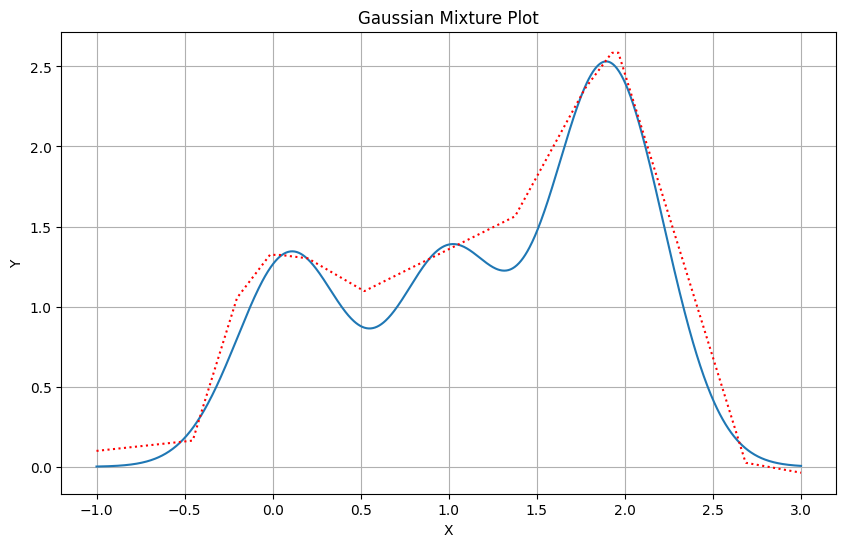

In [37]:
test_X = torch.linspace(-1, 3, 1000)
test_Y = gaussian_mixture(test_X)
model_Y = model(test_X.reshape(-1, 1).to(device))
model_Y = model_Y.cpu()
plt.figure(figsize=(10, 6))
plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
plt.title('Gaussian Mixture Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [38]:
import torch.profiler

X = torch.randn(1000, 1).to(device)
Y = gaussian_mixture(X).to(device)
y_pred = model(X)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
        record_shapes=True,
        profile_memory=True
) as prof_with_grad:
    loss = L(y_pred, Y)
    loss.backward()
    optimizer.step()

prof_with_grad.export_chrome_trace("trace_with_grad.json")